# Estimate rates - Test 1

- test_name = "test_1"

- N = 100, I0 = 10

In [1]:
import numpy as np
import matplotlib.pylab as plt

import sys
sys.path.append('../src/')
from solve_kolmogorov import *
from simulate_gillespie import *
from Hypergraphs import *
from estimate_total_rates import *

from scipy.integrate import solve_ivp

## Setup

In [2]:
## --- Setup --- ##
test_name = "test_1"

g_type = "complete"

# TODO: increase these values
N = 100
g = CompleteHypergraph(N)

I0 = 10

nsims = 500
run_gillespie_simulations = False

time_max = 10

# TODO: select betas for 3 regimes: .25N, .5N, .75N
# betas for regime .75N only:
beta1 = 2.4 / N       # pairwise infection rate
beta2 = 4.4 / (N**2)  # hyperedge contagion rate
mu    = 1             # recovery rate

print(f"{test_name}: \n")
print(f"\t H = Complete Hypergraph, N = {N}, I0 = {I0}, time_max = {time_max},")
print(f"\t beta1 * N = {beta1 * N}, beta2 * N^2 = {beta2 * (N**2)}, mu = {mu},")
print(f"\t with estimation based on {nsims} Gillespie simulation runs\n")

test_1: 

	 H = Complete Hypergraph, N = 100, I0 = 10, time_max = 10,
	 beta1 * N = 2.4, beta2 * N^2 = 4.4, mu = 1,
	 with estimation based on 500 Gillespie simulation runs



## Run Gillespie

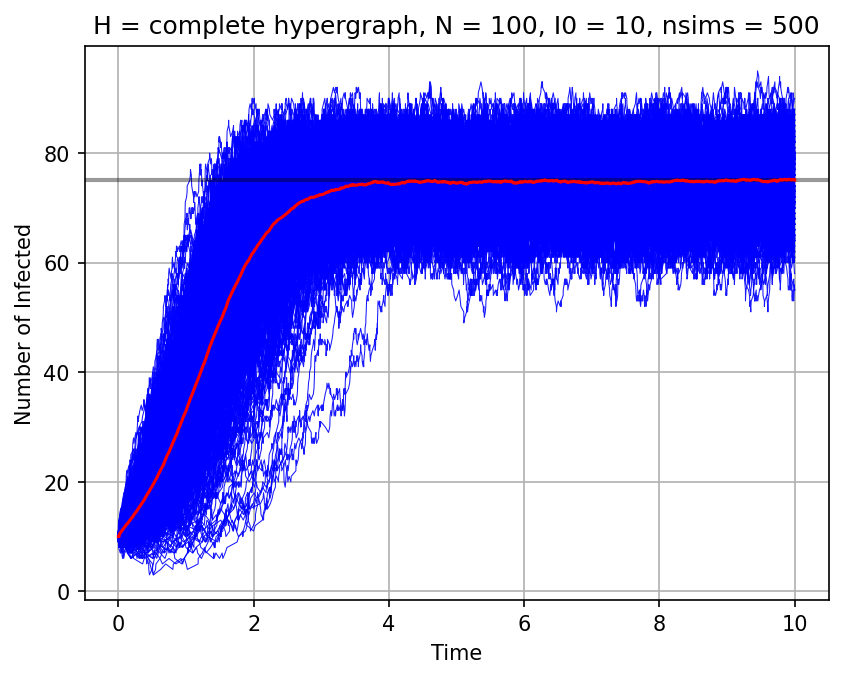

In [3]:
## --- Run Gillespie ---
# I0_gillespie = I0 # TODO: go over the range when necessary
# initial_infections = list(range(I0_gillespie))
if run_gillespie_simulations: 
    X_sims = []
    for _ in range(nsims):
        # X_t = gillespie_sim(g, beta1, beta2, mu, initial_infections, time_max)
        X_t = gillespie_sim_complete(N, beta1, beta2, mu, I0, time_max)
        X_sims.append(X_t)

    # save the simulation results
    sim_results = {f'sim_{i}': X_sims[i] for i in range(nsims)}
    np.savez_compressed(f'../results/gillespie-sims_{test_name}.npz', **sim_results)
else: 
    # load simulation results
    sim_results = np.load(f'../results/gillespie-sims_{test_name}.npz', allow_pickle=True)
    X_sims = [sim_results[f'sim_{i}'] for i in range(nsims)]

# plot X_t curves in gray and average curve in red
fig = plt.figure(dpi=150) # set DPI
ax  = plt.subplot()

for X_t in X_sims:
    ax.plot(X_t[0], X_t[2], c="blue", alpha=0.9, linewidth=0.5, rasterized=True)

avg_curve, times = get_average(X_sims, time_max, nsims, delta_t = 0.01)
# avg_curve, times = get_average_corrected(X_sims, time_max, nsims, delta_t = 0.01)

plt.axhline(y=int(0.75 * N), color='black', lw=2, alpha=0.4, linestyle='-')

plt.plot(times, avg_curve, "red")

plt.xlabel("Time")
plt.ylabel("Number of Infected")
plt.grid(True)
plt.title(f"H = complete hypergraph, N = {N}, I0 = {I0}, nsims = {nsims}")
plt.savefig(f"../figures/estimation/complete/{test_name}/gillespie-sims.pdf", 
            format='pdf', bbox_inches='tight')
plt.show()
plt.close(fig) # free up memory

## Solve KEs and compare

In [4]:
# solve KEs and compare
all_states = list_all_states(g)
M = len(all_states)
ode_system_complete = list_all_ODEs_complete(g, beta1, beta2, mu)

# set the initial condition
p0 = np.zeros(M)
i_set0 = all_states.index(I0)
p0[i_set0] = 1.0 # all other states have prob 0 at time 0
p0

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [5]:
# solve ode_system_complete over time
t_span = (0.0, time_max)

# times t_i to evaluate in, get saved in sol.t
steps_eval = 202
t_eval = np.linspace(t_span[0], t_span[1], steps_eval)

def f_ode(t, p):
    return ode_system_complete(t, p)

sol = solve_ivp(f_ode, 
                t_span, 
                p0, 
                t_eval=t_eval,
                method="LSODA")

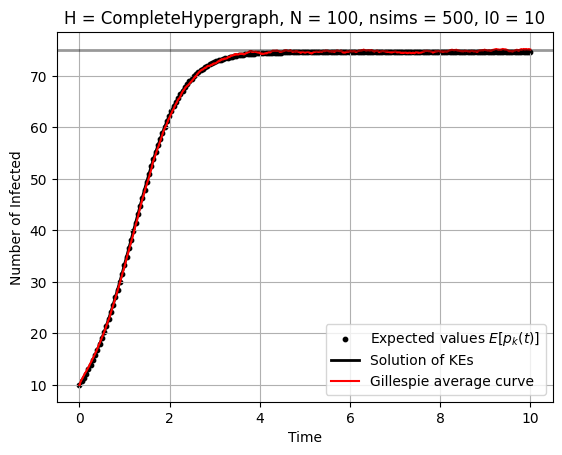

In [6]:
# plot both the expected values of p_{k}(t) 
# and the Gillespie average curve
# on the same figure

expected_values = calculate_expected_values(sol)

plt.figure()
plt.scatter(sol.t, expected_values, s = 10, color="k", 
            label=r"Expected values $E[p_{k}(t)]$")
plt.plot(sol.t, expected_values, lw=2, color="k", label="Solution of KEs")
plt.plot(times, avg_curve, 'red', label="Gillespie average curve")

plt.axhline(y=int(0.75 * N), color='black', lw=2, alpha=0.4, linestyle='-')

plt.xlabel("Time")
plt.ylabel("Number of Infected")
plt.legend()
plt.grid(True)
plt.title(f"H = {g.__class__.__name__}, N = {N}, nsims = {nsims}, I0 = {I0}")
plt.savefig(f"../figures/estimation/complete/{test_name}/solution-vs-gillespie.pdf", 
            format='pdf', bbox_inches='tight')
plt.show()

## Check solution probabilities

In [7]:
# check the probabilities
p_vals = sol.y # matrix of shape (M x ntimes)
M, ntimes = p_vals.shape # M = N + 1 for complete case
np.sum(p_vals[:, ntimes - 1])

np.float64(0.9999999999944299)

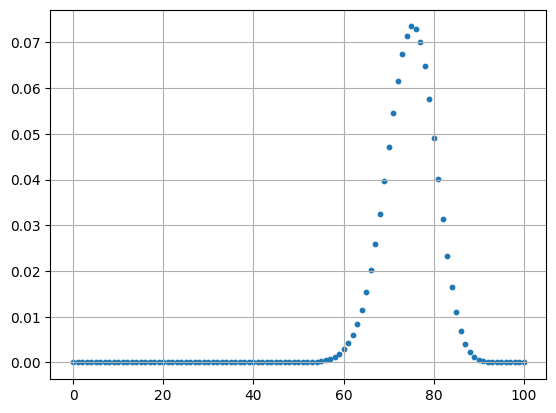

In [8]:
plt.figure()
plt.scatter([k for k in range(N + 1)], p_vals[:, ntimes - 1], s=10, alpha=1)
plt.grid(True)
plt.savefig(f"../figures/estimation/complete/{test_name}/solution_p_at_time_max.pdf", 
            format='pdf', bbox_inches='tight')    
plt.show()

In [9]:
p_vals[0, ntimes - 1]

np.float64(0.00018964249492864306)

## Calculate the estimates

In [10]:
## --- Calculate the estimates ---
min_Tk_threshold = 1e-6
estimates = calculate_estimates(X_sims, N, min_Tk_threshold)

Total events processed: 691186


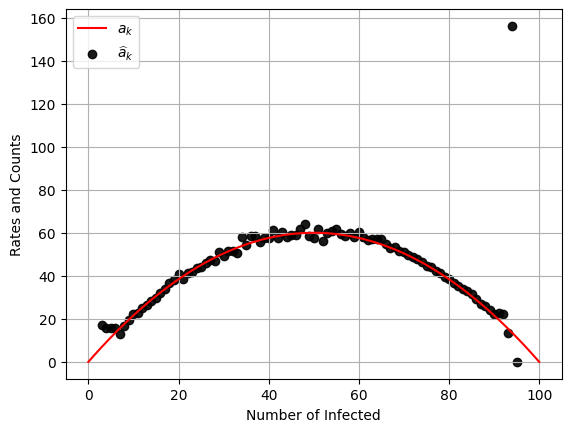

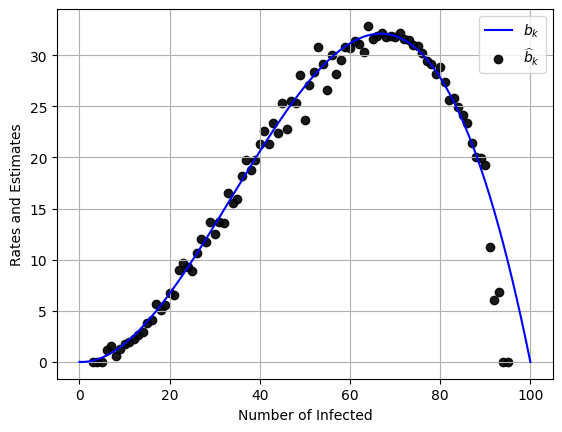

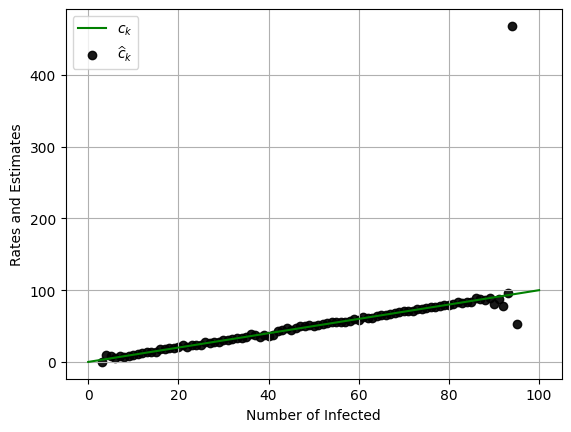

In [11]:
a_k_hat = estimates["a_k_hat"]
b_k_hat = estimates["b_k_hat"]
c_k_hat = estimates["c_k_hat"]

# plot only where T_k was non-zero!
valid_k_idx = estimates["T_k"] > min_Tk_threshold   

# and compare them to theoretical rates
k_values = np.arange(0, N + 1) # number of infected from 0 to N
k_choose_2 = np.array(list(map(lambda k: comb(k, 2, exact=True), k_values)))
a_k = beta1 * k_values * (N - k_values)
b_k = beta2 * k_choose_2 * (N - k_values)
c_k = mu * k_values

fig = plt.figure()
ax = plt.subplot()

# theoretical ak vs. ak hats 
ax.plot(k_values, a_k, label=r'$a_k$', color="red")
ax.scatter(k_values[valid_k_idx], a_k_hat[valid_k_idx],
        label=r'$\widehat{a}_k$', color="black", alpha=0.9)
plt.xlabel("Number of Infected")
plt.ylabel("Rates and Counts")
plt.legend()
plt.grid(True)    
plt.savefig(f"../figures/estimation/complete/{test_name}/estimates_ak.pdf", 
            format='pdf', bbox_inches='tight')    
plt.show()

# theoretical bk vs. bk hats
fig = plt.figure()
ax = plt.subplot()
ax.plot(k_values, b_k, label=r'$b_k$', color="blue")
ax.scatter(k_values[valid_k_idx], b_k_hat[valid_k_idx],
        label=r'$\widehat{b}_k$', color="black", alpha=0.9)
plt.xlabel("Number of Infected")
plt.ylabel("Rates and Estimates")
plt.legend()
plt.grid(True)    
plt.savefig(f"../figures/estimation/complete/{test_name}/estimates_bk.pdf", 
            format='pdf', bbox_inches='tight')
plt.show()

# theoretical ck vs. ck hats (as a test only)
fig = plt.figure()
ax = plt.subplot()
ax.plot(k_values, c_k, label=r'$c_k$', color="green")
ax.scatter(k_values[valid_k_idx], c_k_hat[valid_k_idx],
        label=r'$\widehat{c}_k$', color="black", alpha=0.9)
plt.xlabel("Number of Infected")
plt.ylabel("Rates and Estimates")
plt.legend()
plt.grid(True)
plt.savefig(f"../figures/estimation/complete/{test_name}/estimates_ck.pdf", 
            format='pdf', bbox_inches='tight')    
plt.show()

## Solve KEs using the estimates 

In [12]:
## --- Solve KEs using the estimates and compare ---
# --- Model 2 ---
ode_system_complete = list_all_ODEs_using_estimates(g, a_k_hat, b_k_hat, mu)

def f_ode(t, p):
    return ode_system_complete(t, p)

sol_hat = solve_ivp(f_ode, 
                    t_span, 
                    p0, 
                    t_eval=t_eval,
                    method="LSODA")

expected_values_hat = calculate_expected_values(sol_hat)

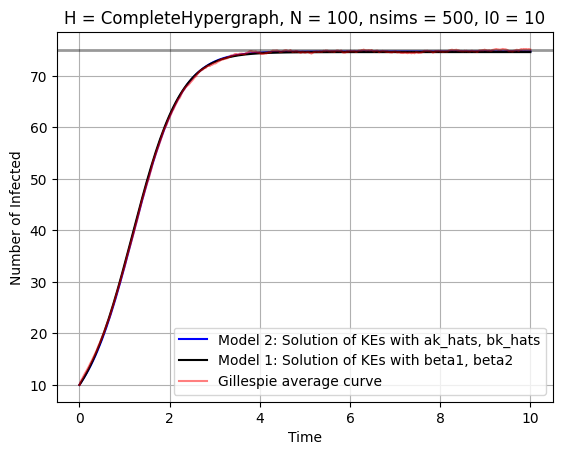

In [14]:
plt.figure()

plt.plot(sol.t, expected_values_hat, color="b", label="Model 2: Solution of KEs with ak_hats, bk_hats")
# plt.scatter(sol.t, expected_values_hat, color="b", s=10, alpha=.8, label="Model 2: Solution of KEs with ak_hats, bk_hats")

plt.plot(sol.t, expected_values, color="k", label="Model 1: Solution of KEs with beta1, beta2")

plt.plot(times, avg_curve, 'red', label="Gillespie average curve", alpha=0.5)

plt.axhline(y=int(0.75 * N), color='black', lw=2, alpha=0.4, linestyle='-')

plt.xlabel("Time")
plt.ylabel("Number of Infected")
plt.legend()
plt.grid(True)
plt.title(f"H = {g.__class__.__name__}, N = {N}, nsims = {nsims}, I0 = {I0}")
plt.savefig(f"../figures/estimation/complete/{test_name}/solutions-comparison.pdf", 
            format='pdf', bbox_inches='tight')
plt.show()